## Libraries

In [2]:
from optbinning import OptimalBinning
from loan_data.preprocess_functions import preprocess
from init_char_analysis import *
import numpy as np
import glob
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

(CVXPY) Nov 23 02:39:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 23 02:39:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


## Read in csv's

In [3]:
path = "../../dataset/"
files = glob.glob(path + "/*.csv") 
processed_df = []
for file in files:
    if file == "../../dataset/2019_stat.csv":
        continue 
    print(file)
    temp_data = pd.read_csv(file)
    processed_df.append(temp_data)
    del temp_data
processed_df = pd.concat(processed_df)

../../dataset/2023_stat.csv
../../dataset/2022_stat.csv
../../dataset/2020_stat.csv
../../dataset/2021_stat.csv


In [4]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG',
       'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV'],
      dtype='object')

# Undo one-hot encoding & filter relevant columns

In [5]:
ONE_HOT_ENCODED_MAP = {
    "PUR": ['PUR_Cash_out','PUR_Refinance', 'PUR_Purchase'],
    "PRO": ['PRO_Condominium', 'PRO_Co_operative','PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family'],
    "MI": ['MI_Borrower', 'MI_Lender', 'MI_Investor'],
    "OCC": ['OCC_Principal', 'OCC_Second', 'OCC_Investor']
}

for new_col, cols in ONE_HOT_ENCODED_MAP.items():
    indices = processed_df[cols].to_numpy().argmax(axis=1)
    categories = [col.split('_', 1)[1] for col in cols]  # Extract category names
    processed_df[new_col] = np.array(categories)[indices] 
    processed_df.drop(columns=cols, inplace=True)

processed_df

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,...,Deed_In_Lieu,Non_Performing_NS,Reperforming_NS,COMPLETE_FLAG,NET_LOSS,NET_SEV,PUR,PRO,MI,OCC
0,135176712,6.50,206000.0,360,60.0,1,36.0,797.0,797.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
1,135176713,6.38,162000.0,360,50.0,1,41.0,746.0,746.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
2,135176714,7.62,206000.0,360,75.0,2,26.0,799.0,806.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
3,135176715,6.75,361000.0,360,85.0,1,48.0,788.0,788.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
4,135176716,7.00,350000.0,360,50.0,2,37.0,619.0,671.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782087,129937967,2.50,160000.0,360,62.0,1,17.0,803.0,803.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
4782088,129937968,2.99,450000.0,360,90.0,1,36.0,740.0,740.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Condominium,Borrower,Principal
4782089,129937969,2.50,153000.0,180,70.0,2,31.0,770.0,724.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
4782090,129937970,2.50,250000.0,180,51.0,2,40.0,755.0,711.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Planned_Urban,Borrower,Principal


In [6]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'STATE', 'ZIP',
       'MSA', 'MI_PCT', 'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE',
       'LAST_UPB', 'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG',
       'DLQ_90_FLAG', 'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ',
       'Prepaid_Matured', 'Third_Party_Sale', 'Short_Sale', 'Repurchased',
       'Deed_In_Lieu', 'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG',
       'NET_LOSS', 'NET_SEV', 'PUR', 'PRO', 'MI', 'OCC'],
      dtype='object')

In [8]:
processed_df = processed_df[(processed_df['DLQ_90_FLAG'] == 1) | (processed_df['DLQ_90_FLAG'] == 0) & (processed_df['Ongoing'] == 1)]

RELEVANT_COLUMNS = [
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
    'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'MI_PCT', 
    'DLQ_90_FLAG', 'PUR', 'PRO', 'MI', 'OCC'
]
processed_df = processed_df[RELEVANT_COLUMNS]

## WOE on Categorical Variables

In [13]:
CAT_COLUMNS = [
    'PUR',
    'PRO',
    'OCC',
    'MI',
    'FTHB_FLAG'  # not sure if this should be here
]

COLUMN: PUR
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Refinance],3784126,0.370646,3735200,48926,0.012929,0.313313,0.031385,0.003907
1,[Cash_out],2281704,0.223487,2238473,43231,0.018947,-0.074944,0.001302,0.000163
2,[Purchase],4143713,0.405867,4056153,87560,0.021131,-0.186269,0.015423,0.001925
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.048110,0.005995


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.11162577
    IV (Jeffrey)             0.04810957
    JS (Jensen-Shannon)      0.00599491
    Hellinger                0.00600428
    Triangular               0.02390514
    KS                       0.10017012
    HHI                      0.35205278
    HHI (normalized)         0.19006598
    Cramer's V               0.02799313
    Quality score            0.16114265

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1  3444.943078 0.000000e+00  0.000000e+00       1.0
        1      2   351.972494 1.576175e-78 1.648367e-104       1.0

None


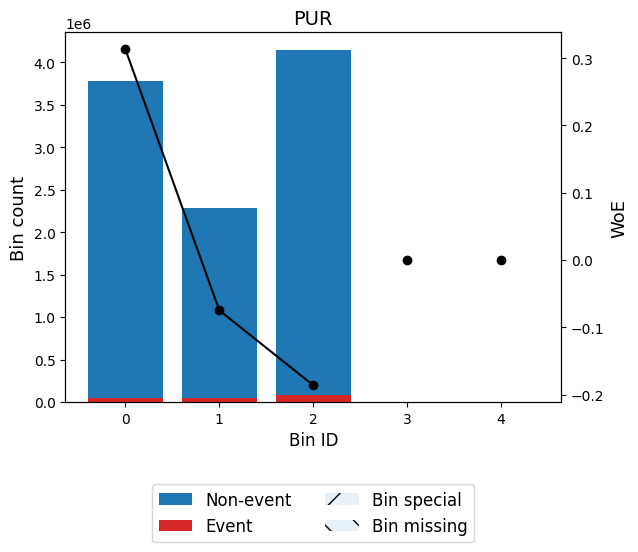


COLUMN: PRO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Co_operative, Condominium]",928008,0.090896,913308,14700,0.015840,0.107291,0.000994,0.000124
1,[Single_Family],6383439,0.625242,6270562,112877,0.017683,-0.004613,0.000013,0.000002
2,"[Planned_Urban, Manufact_Home]",2898096,0.283861,2845956,52140,0.017991,-0.022213,0.000142,0.000018
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.001149,0.000144


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01242845
    IV (Jeffrey)             0.00114884
    JS (Jensen-Shannon)      0.00014355
    Hellinger                0.00014358
    Triangular               0.00057394
    KS                       0.00926394
    HHI                      0.47976749
    HHI (normalized)         0.34970936
    Cramer's V               0.00436270
    Quality score            0.00310939

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1   160.416976 9.173708e-37 2.112156e-39  1.000000
        1      2    10.851082 9.873803e-04 2.655636e-04  0.999734

None


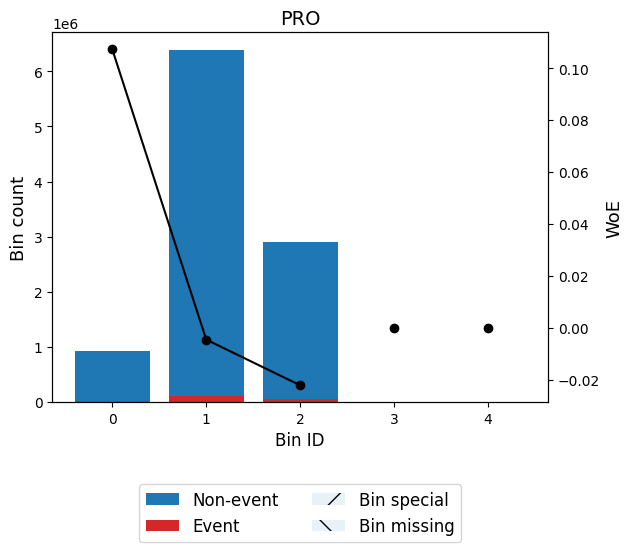


COLUMN: OCC
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Second, Investor]",932916,0.091377,921768,11148,0.011950,0.393098,0.011743,0.001458
1,[Principal],9276627,0.908623,9108058,168569,0.018171,-0.032366,0.000967,0.000121
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.012709,0.001579


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02987183
    IV (Jeffrey)             0.01270938
    JS (Jensen-Shannon)      0.00157929
    Hellinger                0.00158396
    Triangular               0.00628019
    KS                       0.02987183
    HHI                      0.83394574
    HHI (normalized)         0.77859432
    Cramer's V               0.01363285
    Quality score            0.01171731

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  1897.491874      0.0       0.0       1.0

None


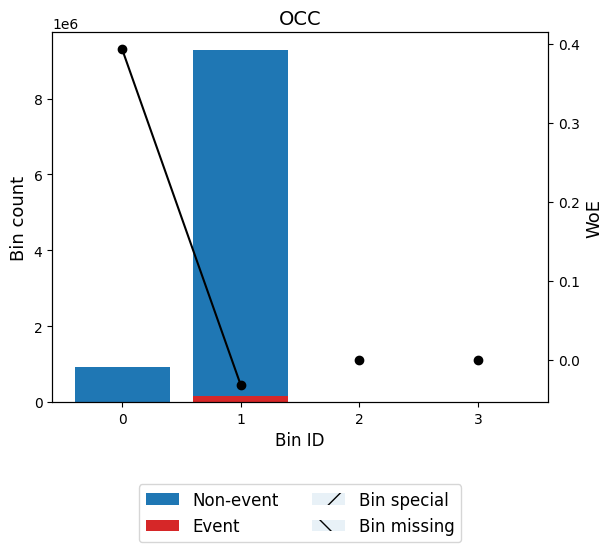


COLUMN: MI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Borrower, Lender, Investor]",10209543,1.0,10029826,179717,0.017603,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,10209543,1.0,10029826,179717,0.017603,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


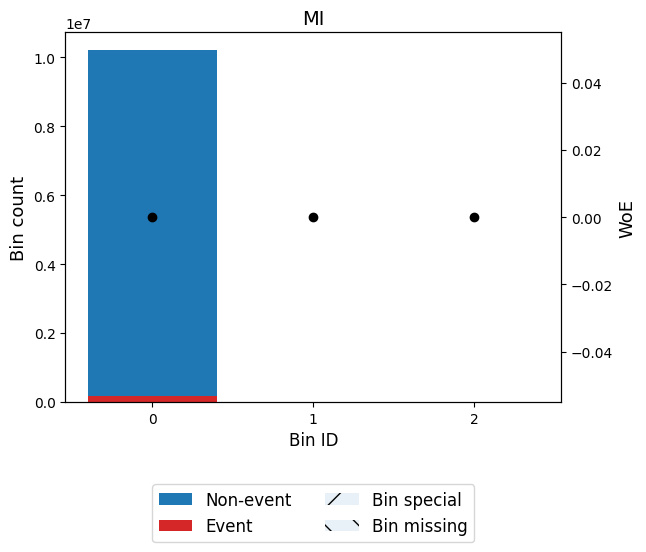


COLUMN: FTHB_FLAG
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],8201692,0.803336,8071222,130470,0.015908,0.102982,0.008110,0.001013
1,[1],2007851,0.196664,1958604,49247,0.024527,-0.338796,0.026679,0.003319
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.034789,0.004332


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07874731
    IV (Jeffrey)             0.03478883
    JS (Jensen-Shannon)      0.00433230
    Hellinger                0.00434043
    Triangular               0.01726469
    KS                       0.07874731
    HHI                      0.68402529
    HHI (normalized)         0.57870038
    Cramer's V               0.02605311
    Quality score            0.06082630

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  6929.874495      0.0       0.0       1.0

None


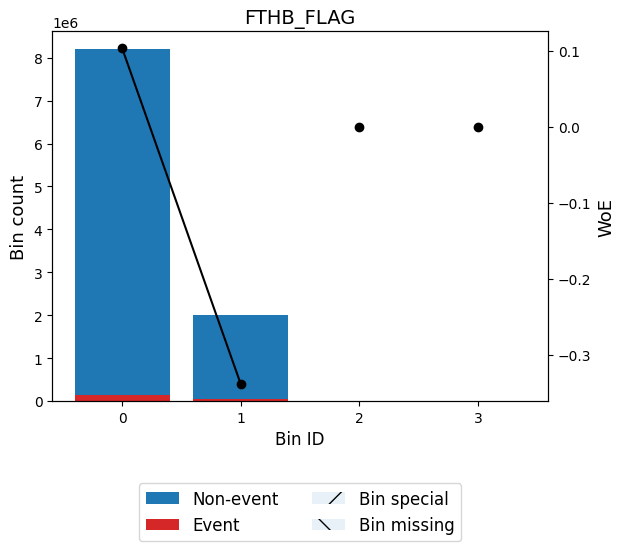

In [15]:
opt_bin_data = processed_df.copy()

for col in CAT_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="categorical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(opt_bin_data[col], metric="woe")
    print()


## Numerical variables

In [16]:
NUMERICAL_COLUMNS = [
    "ORIG_RATE",
    "ORIG_AMOUNT",	
    "ORIG_TERM",
    "OLTV",
    "NUM_BO", 
    "DTI",
    "CSCORE_B", 
    "CSCORE_C",
    "NUM_UNIT",
    "MI_PCT"]

COLUMN: ORIG_RATE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.59)",1189582,0.116517,1183836,5746,0.004830,1.306076,0.112400,0.013129
1,"[2.59, 2.69)",531496,0.052059,527704,3792,0.007135,0.913707,0.028794,0.003479
2,"[2.69, 2.81)",881843,0.086374,874300,7543,0.008554,0.730868,0.033034,0.004040
3,"[2.81, 2.99)",1135095,0.111180,1122915,12180,0.010730,0.501953,0.022178,0.002744
4,"[2.99, 3.10)",1060614,0.103885,1045658,14956,0.014101,0.225354,0.004740,0.000591
5,"[3.10, 3.23)",653367,0.063996,643221,10146,0.015529,0.127474,0.000978,0.000122
6,"[3.23, 3.34)",794012,0.077772,778776,15236,0.019189,-0.087873,0.000627,0.000078
7,"[3.34, 3.55)",1036402,0.101513,1007447,28955,0.027938,-0.472503,0.028666,0.003550
8,"[3.55, 4.11)",889859,0.087160,846979,42880,0.048187,-1.038665,0.160112,0.019160
9,"[4.11, 5.06)",551822,0.054050,527986,23836,0.043195,-0.924062,0.073915,0.008924


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.39847375
    IV (Jeffrey)             0.52976371
    JS (Jensen-Shannon)      0.06346236
    Hellinger                0.06480018
    Triangular               0.24403045
    KS                       0.23566604
    HHI                      0.08852077
    HHI (normalized)         0.01840698
    Cramer's V               0.10156349
    Quality score            0.88433385

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1   353.942381  5.870076e-79 6.199795e-176       1.0
        1      2    83.944397  5.088878e-20  3.297679e-24       1.0
        2      3   242.837880  9.460976e-55  9.908557e-78       1.0
        3      4   510.425925 5.123251e-113 2.911573e-190       1.0
        4      5    57.092834  4.15717

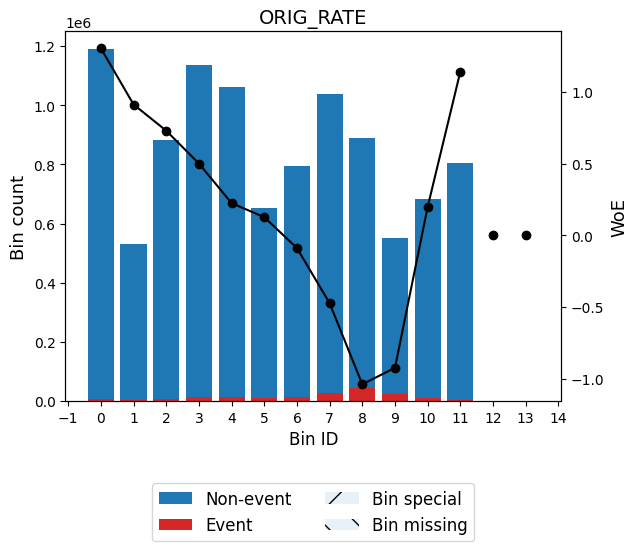


COLUMN: ORIG_AMOUNT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 151500.00)",1887043,0.184831,1856727,30316,0.016065,0.09296,0.001528,1.908837e-04
1,"[151500.00, 205500.00)",1651368,0.161747,1624253,27115,0.016420,0.070781,0.000783,9.788918e-05
2,"[205500.00, 250500.00)",1357368,0.132951,1334962,22406,0.016507,0.065394,0.000551,6.885946e-05
3,"[250500.00, 321500.00)",1789948,0.175321,1759588,30360,0.016961,0.037774,0.000246,3.070494e-05
4,"[321500.00, 350500.00)",602147,0.058979,591440,10707,0.017781,-0.010273,0.000006,7.818466e-07
5,"[350500.00, 402500.00)",870613,0.085274,853844,16769,0.019261,-0.091719,0.000750,9.371869e-05
6,"[402500.00, 450500.00)",588477,0.057640,576332,12145,0.020638,-0.162169,0.001641,2.048514e-04
7,"[450500.00, 510500.00)",648906,0.063559,634573,14333,0.022088,-0.231547,0.003817,4.760569e-04
8,"[510500.00, inf)",813673,0.079697,798107,15566,0.019131,-0.084782,0.000597,7.459164e-05
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05215125
    IV (Jeffrey)             0.00991827
    JS (Jensen-Shannon)      0.00123834
    Hellinger                0.00123906
    Triangular               0.00494759
    KS                       0.04242802
    HHI                      0.13320225
    HHI (normalized)         0.04652247
    Cramer's V               0.01344728
    Quality score            0.01738307

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     6.926404 8.493231e-03 3.895980e-03  0.996104
        1      2     0.350147 5.540299e-01 2.771035e-01  0.722897
        2      3     9.671221 1.871769e-03 8.075840e-04  0.999192
        3      4    17.954908 2.262004e-05 4.039463e-07  1.000000
        4      5    42.573640 6.807058e-11 1.268

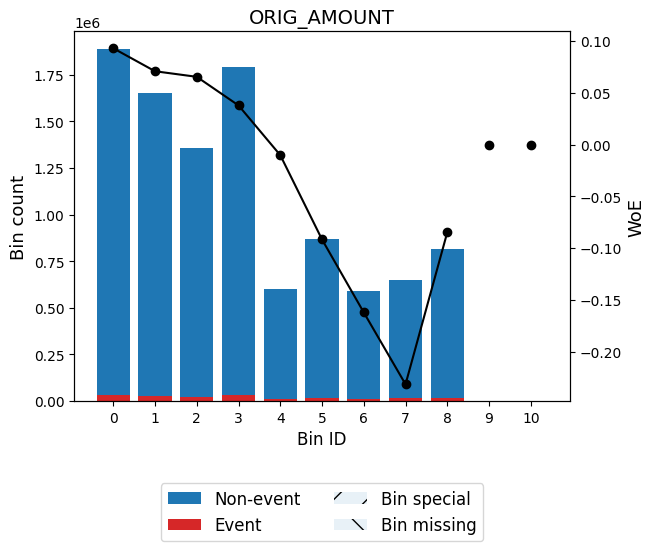


COLUMN: ORIG_TERM
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 228.50)",1766301,0.173005,1752915,13386,0.007579,0.852891,0.085533,0.010379
1,"[228.50, 322.50)",665065,0.065142,658435,6630,0.009969,0.576326,0.016573,0.002043
2,"[322.50, inf)",7778177,0.761854,7618476,159701,0.020532,-0.156907,0.020248,0.002528
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.122354,0.014951


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13060064
    IV (Jeffrey)             0.12235414
    JS (Jensen-Shannon)      0.01495076
    Hellinger                0.01511962
    Triangular               0.05851755
    KS                       0.12904282
    HHI                      0.61459501
    HHI (normalized)         0.51824376
    Cramer's V               0.04003501
    Quality score            0.23411387

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1   338.129453 1.630218e-75 7.240074e-192       1.0
        1      2  3539.832409 0.000000e+00  0.000000e+00       1.0

None


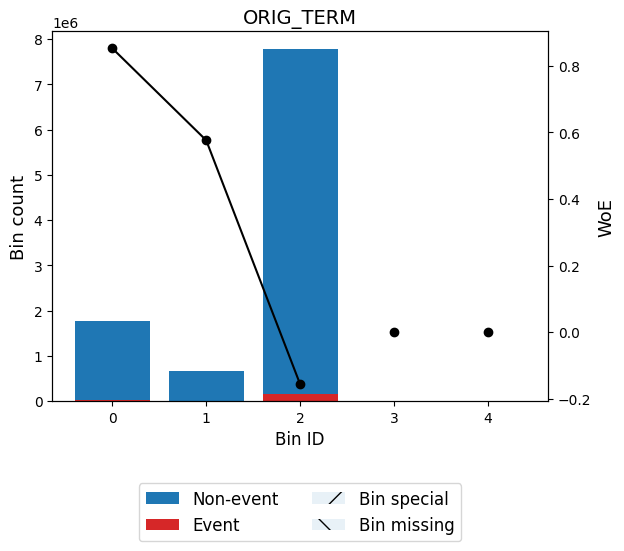


COLUMN: OLTV
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 35.50)",553360,0.054200,550481,2879,0.005203,1.231414,0.047859,5.630869e-03
1,"[35.50, 44.50)",574907,0.056311,571151,3756,0.006533,1.002364,0.036131,4.336310e-03
2,"[44.50, 54.50)",1000330,0.097980,992038,8292,0.008289,0.762535,0.040239,4.911409e-03
3,"[54.50, 59.50)",699352,0.068500,692130,7222,0.010327,0.540707,0.015584,1.924627e-03
4,"[59.50, 64.50)",758756,0.074318,749023,9733,0.012828,0.321312,0.006594,8.207267e-04
5,"[64.50, 68.50)",564427,0.055284,556259,8168,0.014471,0.199075,0.001993,2.487129e-04
6,"[68.50, 76.50)",1772214,0.173584,1741158,31056,0.017524,0.004579,0.000004,4.538485e-07
7,"[76.50, 80.50)",1859097,0.182094,1824418,34679,0.018654,-0.059053,0.000653,8.166769e-05
8,"[80.50, 92.50)",1015270,0.099443,989897,25373,0.024991,-0.35802,0.015211,1.891342e-03
9,"[92.50, inf)",1411830,0.138285,1363271,48559,0.034394,-0.687072,0.092257,1.131050e-02


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.27370256
    IV (Jeffrey)             0.25652479
    JS (Jensen-Shannon)      0.03115662
    Hellinger                0.03160032
    Triangular               0.12131112
    KS                       0.18782831
    HHI                      0.12128188
    HHI (normalized)         0.04139841
    Cramer's V               0.06551163
    Quality score            0.83035515

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]  P[B > A]
        0      1    85.375966  2.467011e-20 3.470220e-27       1.0
        1      2   148.329032  4.019822e-34 4.393849e-43       1.0
        2      3   188.914959  5.484986e-43 6.042832e-74       1.0
        3      4   198.044654  5.578821e-45 5.458602e-66       1.0
        4      5    65.525936  5.735418e-16

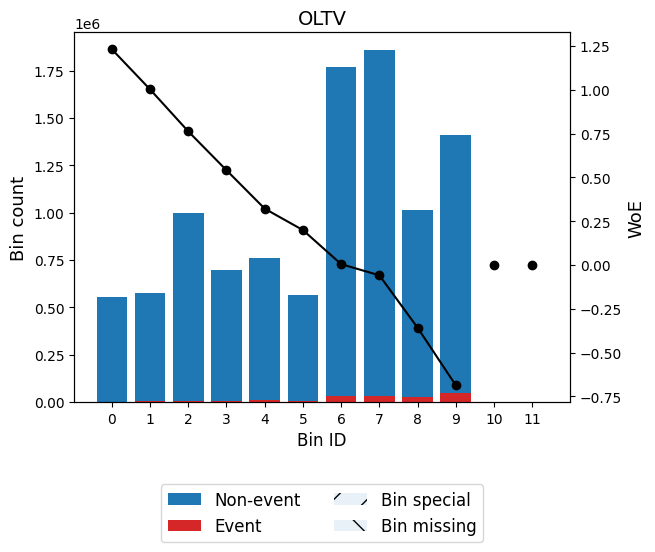


COLUMN: NUM_BO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",5437608,0.532601,5313477,124131,0.022828,-0.265271,0.042691,0.005321
1,"[1.50, inf)",4771935,0.467399,4716349,55586,0.011649,0.418924,0.067419,0.008366
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.110111,0.013687


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16093499
    IV (Jeffrey)             0.11011086
    JS (Jensen-Shannon)      0.01368718
    Hellinger                0.01372537
    Triangular               0.05444664
    KS                       0.16093499
    HHI                      0.50212559
    HHI (normalized)         0.33616745
    Cramer's V               0.04241706
    Quality score            0.29296526

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1 18369.079713      0.0       1.0       0.0

None


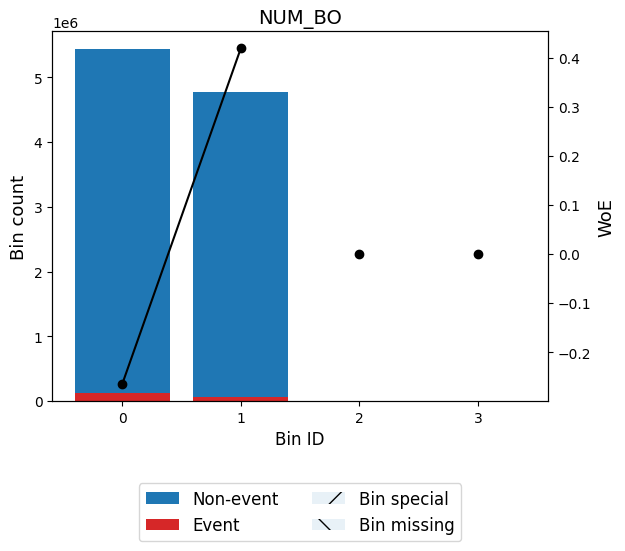


COLUMN: DTI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 17.50)",594678,0.058247,592039,2639,0.004438,1.391237,0.061693,0.007144
1,"[17.50, 22.50)",882065,0.086396,876581,5484,0.006217,1.052259,0.059855,0.007155
2,"[22.50, 25.50)",717342,0.070262,711370,5972,0.008325,0.758176,0.028580,0.003489
3,"[25.50, 27.50)",538428,0.052738,532981,5447,0.010116,0.561486,0.012819,0.001582
4,"[27.50, 29.50)",578669,0.056679,571782,6887,0.011901,0.397187,0.007422,0.000922
5,"[29.50, 31.50)",609947,0.059743,601883,8064,0.013221,0.290718,0.004401,0.000548
6,"[31.50, 33.50)",632010,0.061904,622578,9432,0.014924,0.167826,0.001609,0.000201
7,"[33.50, 35.50)",657429,0.064394,646368,11061,0.016825,0.046008,0.000133,0.000017
8,"[35.50, 37.50)",675314,0.066145,662622,12692,0.018794,-0.066702,0.000304,0.000038
9,"[37.50, 39.50)",699207,0.068486,684527,14680,0.020995,-0.179693,0.002414,0.000301


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.26730980
    IV (Jeffrey)             0.26257742
    JS (Jensen-Shannon)      0.03172988
    Hellinger                0.03225781
    Triangular               0.12307751
    KS                       0.20806626
    HHI                      0.09711217
    HHI (normalized)         0.03262018
    Cramer's V               0.06164973
    Quality score            0.84868573

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1   205.623941 1.237784e-46 9.433216e-63  1.000000
        1      2   247.192948 1.062713e-55 4.953515e-92  1.000000
        2      3   109.530244 1.241951e-25 1.412784e-39  1.000000
        3      4    81.383028 1.859480e-19 9.848559e-26  1.000000
        4      5    41.618214 1.109547e-10 5.333

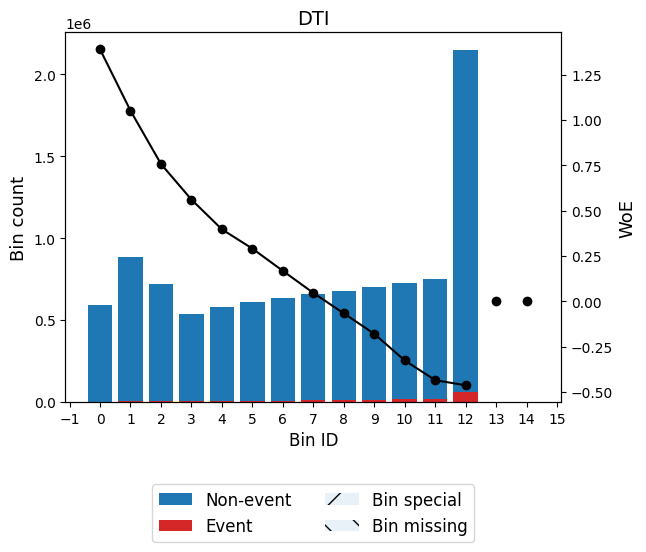


COLUMN: CSCORE_B
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 677.50)",517741,0.050711,480861,36880,0.071233,-1.454026,0.228672,2.630537e-02
1,"[677.50, 702.50)",675423,0.066156,644550,30873,0.045709,-0.983265,0.105724,1.270760e-02
2,"[702.50, 724.50)",882993,0.086487,853318,29675,0.033607,-0.663108,0.053077,6.515671e-03
3,"[724.50, 744.50)",1023605,0.100260,999231,24374,0.023812,-0.308466,0.011104,1.382558e-03
4,"[744.50, 753.50)",575227,0.056342,564994,10233,0.017789,-0.010738,0.000007,8.162525e-07
5,"[753.50, 761.50)",586259,0.057423,577784,8475,0.014456,0.200144,0.002091,2.609807e-04
6,"[761.50, 769.50)",646398,0.063313,638535,7863,0.012164,0.375073,0.007468,9.280995e-04
7,"[769.50, 777.50)",745503,0.073020,738143,7360,0.009873,0.586142,0.019133,2.357915e-03
8,"[777.50, 783.50)",622463,0.060969,617307,5156,0.008283,0.76327,0.025079,3.060954e-03
9,"[783.50, 788.50)",557472,0.054603,553645,3827,0.006865,0.952507,0.032295,3.890875e-03


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.49500565
    IV (Jeffrey)             0.84518670
    JS (Jensen-Shannon)      0.09876986
    Hellinger                0.10204124
    Triangular               0.37225963
    KS                       0.38144104
    HHI                      0.07519514
    HHI (normalized)         0.01354148
    Cramer's V               0.13174028
    Quality score            0.35505679

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  3564.722368  0.000000e+00       1.0 0.000000e+00
        1      2  1500.881360  0.000000e+00       1.0 0.000000e+00
        2      3  1651.326557  0.000000e+00       1.0 0.000000e+00
        3      4   630.744576 3.442573e-139       1.0 0.000000e+00
        4      5   203.580602  3.455398e-46

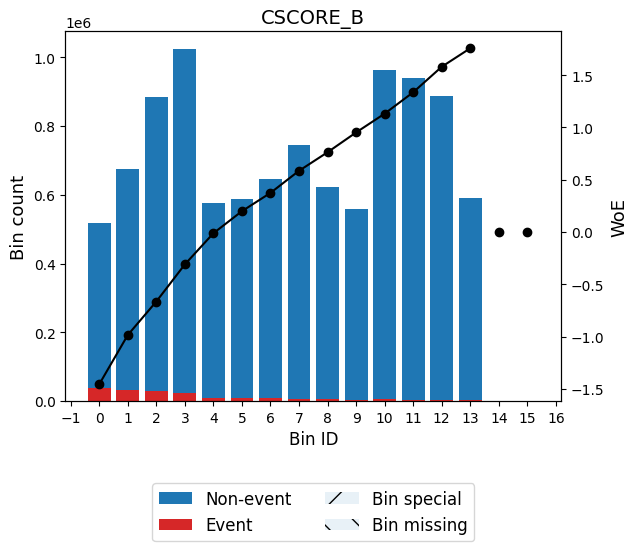


COLUMN: CSCORE_C
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 678.50)",520577,0.050989,485166,35411,0.068023,-1.404467,0.208795,0.024146
1,"[678.50, 703.50)",688639,0.067451,657649,30990,0.045002,-0.966928,0.103334,0.012436
2,"[703.50, 724.50)",837048,0.081987,809296,27752,0.033155,-0.649078,0.047858,0.005879
3,"[724.50, 744.50)",1027633,0.100654,1003072,24561,0.023901,-0.312272,0.011447,0.001425
4,"[744.50, 753.50)",576913,0.056507,566556,10357,0.017952,-0.020022,0.000023,0.000003
5,"[753.50, 765.50)",900779,0.088229,887904,12875,0.014293,0.211641,0.003574,0.000446
6,"[765.50, 774.50)",781808,0.076576,773145,8663,0.011081,0.46947,0.013559,0.001679
7,"[774.50, 780.50)",588882,0.057680,583386,5496,0.009333,0.642893,0.017733,0.002179
8,"[780.50, 786.50)",622349,0.060958,617347,5002,0.008037,0.793658,0.026761,0.003260
9,"[786.50, 795.50)",1049531,0.102799,1042616,6915,0.006589,0.99386,0.065072,0.007815


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.47613432
    IV (Jeffrey)             0.77136363
    JS (Jensen-Shannon)      0.09078315
    Hellinger                0.09347970
    Triangular               0.34404929
    KS                       0.36706364
    HHI                      0.07553230
    HHI (normalized)         0.01390112
    Cramer's V               0.12601267
    Quality score            0.47414924

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  3027.403953  0.000000e+00       1.0 0.000000e+00
        1      2  1432.439043  0.000000e+00       1.0 0.000000e+00
        2      3  1448.775205  0.000000e+00       1.0 0.000000e+00
        3      4   614.062086 1.462991e-135       1.0 0.000000e+00
        4      5   304.306580  3.797822e-68

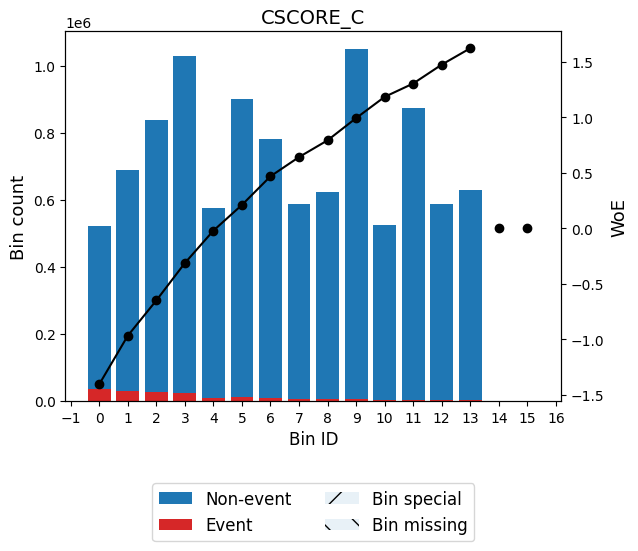


COLUMN: NUM_UNIT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",10209543,1.0,10029826,179717,0.017603,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,10209543,1.0,10029826,179717,0.017603,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


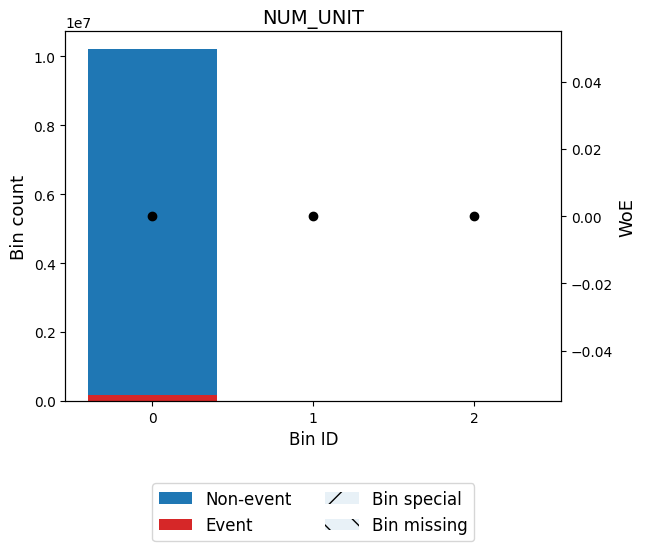


COLUMN: MI_PCT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.50)",7814851,0.765446,7708199,106652,0.013647,0.258534,0.045265,0.005642
1,"[11.50, 27.50)",1234360,0.120903,1199158,35202,0.028518,-0.493663,0.037674,0.004662
2,"[27.50, inf)",1160332,0.113652,1122469,37863,0.032631,-0.632624,0.062483,0.007683
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.145422,0.017987


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.17835149
    IV (Jeffrey)             0.14542212
    JS (Jensen-Shannon)      0.01798712
    Hellinger                0.01808166
    Triangular               0.07121052
    KS                       0.17508355
    HHI                      0.61344129
    HHI (normalized)         0.51680162
    Cramer's V               0.05486246
    Quality score            0.27363536

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1 15278.033007 0.000000e+00  0.000000e+00       1.0
        1      2   342.009142 2.329801e-76 3.740342e-126       1.0

None


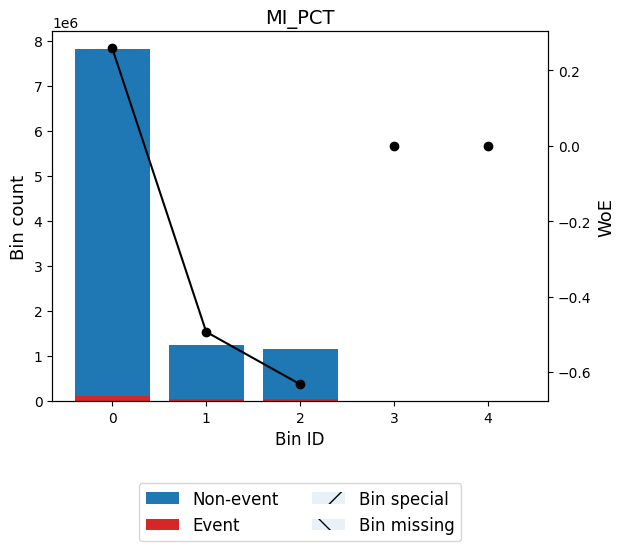

In [18]:

for col in NUMERICAL_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(processed_df[col], metric="woe")
    print()

# Model fitting

In [9]:
opt_bin_data["ORIG_DTE_YR"] = pd.to_datetime(opt_bin_data["ORIG_DTE"]).dt.year - 2000
opt_bin_data["ORIG_DTE_MONTH"] = pd.to_datetime(opt_bin_data["ORIG_DTE"]).dt.month
opt_bin_data["FRST_DTE_YR"] = pd.to_datetime(opt_bin_data["FRST_DTE"]).dt.year - 2000
opt_bin_data["FRST_DTE_MONTH"] = pd.to_datetime(opt_bin_data["FRST_DTE"]).dt.month
opt_bin_data.drop(columns=["ORIG_DTE","FRST_DTE","AQSN_DTE"],inplace=True)

opt_bin_data

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OCLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,...,PROP_TYPE,NUM_UNIT,OCC_STAT,MI_PCT,MI_TYPE,DLQ_FLAG,ORIG_DTE_YR,ORIG_DTE_MONTH,FRST_DTE_YR,FRST_DTE_MONTH
0,135176712,0.234395,0.012536,-0.010366,-0.164310,-0.166844,0.051036,0.925424,0.788982,-0.096966,...,0.092601,0.0,-0.202964,0.0,-0.015745,0,23,1,23,3
1,135176713,0.234395,-0.023530,-0.010366,0.069180,-0.166844,-0.140120,0.006857,0.071224,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,22,12,23,2
2,135176714,0.487422,0.012536,-0.010366,-0.107654,0.245876,0.263661,0.925424,0.867392,-0.096966,...,0.092601,0.0,-0.202964,0.0,-0.015745,0,22,12,23,2
3,135176715,0.377878,0.040724,-0.010366,0.053563,-0.166844,-0.187049,0.754549,0.643629,0.203545,...,-0.057487,0.0,0.019383,12.0,0.030444,0,22,12,23,2
4,135176716,0.377878,0.080062,-0.010366,0.069180,0.245876,0.051036,-1.263778,-1.178734,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,1,22,12,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189369,137429687,-0.365485,0.040724,-0.010366,0.053563,0.245876,0.051036,0.006857,0.395428,0.203545,...,0.092601,0.0,0.019383,0.0,-0.015745,0,23,11,24,1
2189370,137429688,0.377878,-0.023530,-0.010366,-0.290460,-0.166844,0.190595,0.952798,0.867392,0.203545,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,23,11,24,1
2189371,137429689,0.487422,-0.073781,-0.010366,-0.164310,-0.166844,-0.223005,0.925424,0.788982,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,23,10,23,12
2189372,137429690,0.487422,0.085651,-0.010366,0.088295,0.245876,-0.187049,-0.342436,-0.192091,0.203545,...,-0.057487,0.0,0.019383,35.0,0.030444,0,23,11,24,1


In [10]:
opt_bin_data.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OCLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PURPOSE', 'PROP_TYPE',
       'NUM_UNIT', 'OCC_STAT', 'MI_PCT', 'MI_TYPE', 'DLQ_FLAG', 'ORIG_DTE_YR',
       'ORIG_DTE_MONTH', 'FRST_DTE_YR', 'FRST_DTE_MONTH'],
      dtype='object')

In [17]:
X, Y = opt_bin_data.drop(columns=["DLQ_FLAG", "LOAN_ID"]), opt_bin_data["DLQ_FLAG"]
train_split = 0.7
X_train, X_test = X[:int(train_split*len(X))], X[int(train_split*len(X)):]
Y_train, Y_test = Y[:int(train_split*len(X))], Y[int(train_split*len(X)):]


In [18]:
def fit_logistic_regression(
    train: list[pd.DataFrame, pd.DataFrame],
    test: list[pd.DataFrame, pd.DataFrame],
    model_config: dict = {}
):
    logistic_model = linear_model.LogisticRegression(
        C = model_config.get("C", 1),
        solver=model_config.get("solver", "liblinear"),
        random_state=model_config.get("random_state", 0),
        class_weight=model_config.get("class_weight", None)
    )
    logistic_model.fit(train[0], train[1])

    print("Training accuracy:", logistic_model.score(train[0], train[1]))
    print("Testing accuracy:", logistic_model.score(test[0], test[1]))
    print(
        classification_report(
            y_pred=logistic_model.predict(test[0]),
            y_true=test[1]
        )
    )
    # Training AUC
    fpr, tpr, thresholds = metrics.roc_curve(train[1], logistic_model.predict(train[0]), pos_label=1)
    print("Training AUC:", metrics.auc(fpr, tpr))

    # Testing AUC
    fpr, tpr, thresholds = metrics.roc_curve(test[1], logistic_model.predict(test[0]), pos_label=1)
    print("Testing AUC:", metrics.auc(fpr, tpr))
    return logistic_model

In [19]:
woe_model = fit_logistic_regression(
    [X_train, Y_train],
    [X_test, Y_test]
)

Training accuracy: 0.930799491830994
Testing accuracy: 0.9755546860369694


/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    640757
           1       0.00      0.00      0.00     16056

    accuracy                           0.98    656813
   macro avg       0.49      0.50      0.49    656813
weighted avg       0.95      0.98      0.96    656813

Training AUC: 0.5
Testing AUC: 0.5


In [20]:
woe_model = fit_logistic_regression(
    [X_train, Y_train],
    [X_test, Y_test],
    model_config={
        "class_weight": {
            0 :  len(Y_train)/(2*(len(Y_train)-sum(Y_train))),
            1 :  len(Y_train)/(2* sum(Y_train))
        }
    }
)

Training accuracy: 0.6638985332394599
Testing accuracy: 0.904213223550691
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    640757
           1       0.08      0.26      0.12     16056

    accuracy                           0.90    656813
   macro avg       0.53      0.59      0.53    656813
weighted avg       0.96      0.90      0.93    656813

Training AUC: 0.6592765653134359
Testing AUC: 0.5900698305415639


In [21]:
oversample = SMOTE()
X_train_smote, Y_train_smote = oversample.fit_resample(X_train, Y_train)
complete_model = fit_logistic_regression(
    [X_train_smote, Y_train_smote],
    [X_test, Y_test],
    # model_config={"C" : 100,}
)

Training accuracy: 0.6615407425270258
Testing accuracy: 0.9063325482291003
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    640757
           1       0.08      0.25      0.12     16056

    accuracy                           0.91    656813
   macro avg       0.53      0.59      0.53    656813
weighted avg       0.96      0.91      0.93    656813

Training AUC: 0.6615407425270259
Testing AUC: 0.5879074530506412


In [22]:
woe_model = fit_logistic_regression(
    [pd.DataFrame(X_train["CSCORE_B"]), Y_train],
    [pd.DataFrame(X_test["CSCORE_B"]), Y_test],
        model_config={
        "class_weight":"balanced"}
)

Training accuracy: 0.6863576718969098
Testing accuracy: 0.7414180291802994
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    640757
           1       0.05      0.50      0.09     16056

    accuracy                           0.74    656813
   macro avg       0.52      0.62      0.47    656813
weighted avg       0.96      0.74      0.83    656813

Training AUC: 0.6411590718088876
Testing AUC: 0.6230354287016606


In [23]:
no_date_train = X_train.drop(columns=["ORIG_DTE_YR","ORIG_DTE_MONTH", "FRST_DTE_YR", "FRST_DTE_MONTH"])
no_date_test = X_test.drop(columns=["ORIG_DTE_YR","ORIG_DTE_MONTH", "FRST_DTE_YR", "FRST_DTE_MONTH"])
woe_model = fit_logistic_regression(
    [no_date_train, Y_train],
    [no_date_test, Y_test],
    model_config={
        "class_weight": "balanced"
    }
)

Training accuracy: 0.6619371104967436
Testing accuracy: 0.7781727828164181
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    640757
           1       0.05      0.47      0.09     16056

    accuracy                           0.78    656813
   macro avg       0.52      0.63      0.48    656813
weighted avg       0.96      0.78      0.85    656813

Training AUC: 0.6542385442129686
Testing AUC: 0.6299111955717326
